# Importing  Libraries

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow.keras.layers as layer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


from tensorflow.keras.layers import Input, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import re
import seaborn as sns
from gensim.models.fasttext import load_facebook_model

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.tokenize import word_tokenize


# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;color:#484949">Sentiment Analysis through X tweets for KIPK Selection Evaluation  </p>

<a id='0'></a>
## <p style="background-color:#484949; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px; color:white;">[Table of Content](#0)</p>

* [1. Integration Data 💎](#1)
* [2. EDA 📊](#2)
    * [2.1 WordCloud](#2.1)
* [3. Data Preprocessing](#3)
    * [3.1 Cleaning](#3.1)
    * [3.2 Normalization](#3.2)
* [4 Tokenize & Padding](#4)
* [5. Modelling](#5)
    * [5.1 General Model](#5.1)
    * [5.2 Model with Pretrained GloVe](#5.2)
    * [5.3 Model with Pretrained FastText](#5.3)

* [6.Comparison of various neural networks](#6)


<a id='1'></a>
# <p style="background-color:#484949; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">[1. Integration Data](#0) 💎</p>

In [13]:
df1 = "https://raw.githubusercontent.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset/master/Twitter_Emotion_Dataset.csv"
df1 = pd.read_csv(df1, lineterminator="\n")
df1 = df1[['tweet','label']].rename(columns={'tweet':'Tweet'})
df1

,Tweet,label
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",anger
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",anger
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,happy
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",anger
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...",happy
...,...,...
4396,"Tahukah kamu, bahwa saat itu papa memejamkan m...",love
4397,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,fear
4398,"5. masa depannya nggak jelas. lha iya, gimana ...",anger
4399,[USERNAME] dulu beneran ada mahasiswa Teknik U...,happy


In [14]:
# Mendefinisikan mapping dari emosi ke sentimen
emotion_to_sentiment = {
    'happy': 'positive',
    'love': 'positive',
    'anger': 'negative',
    'sadness': 'negative',
    'fear': 'negative'
}
# Mengubah label emosi menjadi label sentimen
df1['label'] = df1['label'].map(emotion_to_sentiment)
df1

,Tweet,label
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",negative
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",negative
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,positive
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",negative
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...",positive
...,...,...
4396,"Tahukah kamu, bahwa saat itu papa memejamkan m...",positive
4397,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,negative
4398,"5. masa depannya nggak jelas. lha iya, gimana ...",negative
4399,[USERNAME] dulu beneran ada mahasiswa Teknik U...,positive


In [15]:
df2 = pd.read_csv("https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/INA_TweetsPPKM_Labeled_Pure.csv", sep="\t")
df2.drop(columns=["Date", "User"], inplace=True)
df2.rename(columns={"sentiment": "label"}, inplace=True)
df2

,Tweet,label
0,Ketahui informasi pembagian #PPKM di wilayah J...,1
1,Tempat Ibadah di Wilayah PPKM Level 1 Boleh Be...,1
2,"Juru bicara Satgas Covid-19, Wiku Adisasmito m...",1
3,Ketahui informasi pembagian #PPKM di wilayah J...,1
4,Kementerian Agama menerbitkan Surat Edaran Nom...,1
...,...,...
23639,noelle loses a bet to akarsha and it somehow e...,1
23640,they call her... weekeeshee...\n#butterflysoup...,1
23641,"put out what you wanna see more of, amirite ga...",1
23642,"i don't need anybody, i'm fine here on my own\...",1


In [16]:
# Menghitung jumlah baris untuk setiap label
label_counts = df2['label'].value_counts()
# Mengambil 70% dari baris dengan label 'neutral'
neutral_rows = df2[df2['label'] == 1]
reduced_neutral_rows = neutral_rows.sample(n=int(len(neutral_rows)*0.3), random_state=1)
# Mengambil semua baris dengan label selain 'neutral'
other_rows = df2[df2['label'] != 1]
# Menggabungkan baris yang telah direduksi dengan baris lainnya
df2 = pd.concat([other_rows, reduced_neutral_rows])
df2

,Tweet,label
33,Karena stimulasi untuk #anakberkebutuhankhusus...,2
35,Hadir Kembali Boss!! MEGA WIN Dari https://t.c...,0
44,Hayolohhhhhhhhh... seneng kannnn??\n\n#covid19...,0
47,Thank You teman-teman dari #saganheritagehotel...,0
51,Ruwet Ruwet Ruwet inilah Negeri RuwetNesia. He...,0
...,...,...
5643,Satpol PP Sidak Pelaksanaan Sekolah Tatap Muka...,1
17877,Perlakuan Petugas PPKM Darurat ke Paspamres Da...,1
12817,Jadi di perpanjang atau stop sampai hari ini s...,1
4932,Polres Kepulauan Seribu Terus bagikan masker d...,1


In [17]:
number_to_sentiment = {
    0: 'positive',
    1: 'neutral',
    2: 'negative'
}
df2['label'] = df2['label'].map(number_to_sentiment)
df2

,Tweet,label
33,Karena stimulasi untuk #anakberkebutuhankhusus...,negative
35,Hadir Kembali Boss!! MEGA WIN Dari https://t.c...,positive
44,Hayolohhhhhhhhh... seneng kannnn??\n\n#covid19...,positive
47,Thank You teman-teman dari #saganheritagehotel...,positive
51,Ruwet Ruwet Ruwet inilah Negeri RuwetNesia. He...,positive
...,...,...
5643,Satpol PP Sidak Pelaksanaan Sekolah Tatap Muka...,neutral
17877,Perlakuan Petugas PPKM Darurat ke Paspamres Da...,neutral
12817,Jadi di perpanjang atau stop sampai hari ini s...,neutral
4932,Polres Kepulauan Seribu Terus bagikan masker d...,neutral


In [18]:
df = pd.concat([df1, df2], ignore_index=True)

<a id='2'></a>
# <p style="background-color:#484949; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">[2. EDA](#0) 📊</p>

In [19]:
# Bagi df menjadi df_train dan df_test
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)

In [20]:
df_train

,Tweet,label
3288,iya rebutan colokan pada penuh semua :d dibis ...,positive
11024,Saya menjual ANOLYTE BABY SANITIZ... seharga R...,neutral
3482,Shawn Mendes kalo pas nyanyi tanpa kita liat o...,positive
7753,Idul Adha di kota orang mbokne ancok tenan #PP...,negative
13616,https://t.co/jpzTC9tVun \n\nKasus Covid Meroke...,neutral
...,...,...
5191,Diperpanjang guys ama pakde\nSemoga kalian seh...,positive
13418,BLT Dana Desa dicairkan lngsung 3 bln\n#BLTDan...,neutral
5390,pls bosen banget 😫😪\n#diperpanjang #ppkm https...,negative
860,Gue punya Temen yg dibela-belain pinjem duwit ...,negative


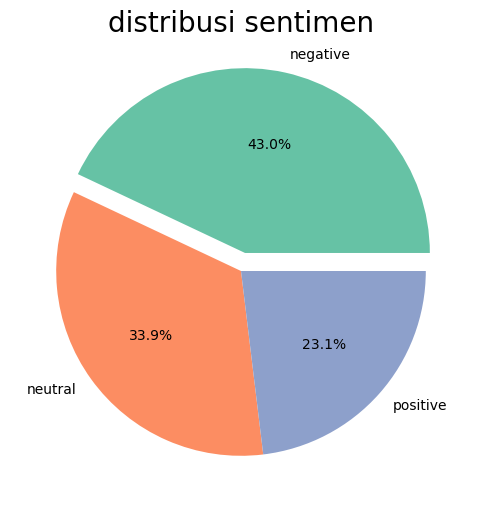

In [21]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in df['label'].value_counts()]
labels = list(df_train['label'].value_counts().index)
explode = (0.1, 0, 0)  # Offset the first segment
# Gunakan palet warna Seaborn
colors = sns.color_palette('Set2')
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, colors=colors, textprops={'fontsize': 10})
ax.set_title('distribusi sentimen', fontsize = 20)
plt.show()

Text(0.5, 1.0, 'Distribution of sentiment in training data')

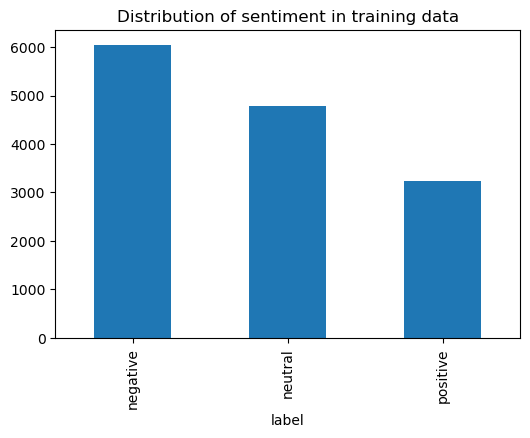

In [22]:
plt.figure(figsize = (6,4))
df_train.label.value_counts().plot(kind = 'bar')
plt.title('Distribution of sentiment in training data')

Text(0.5, 1.0, 'Distribution of sentiment in test data')

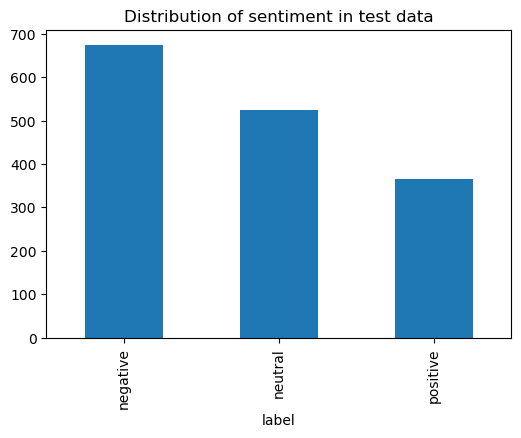

In [23]:
plt.figure(figsize = (6,4))
df_test.label.value_counts().plot(kind = 'bar')
plt.title('Distribution of sentiment in test data')

<a id='2.1'></a>
## <p style="background-color:#484949; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">[2.1 WordCloud](#0) ☁️</p>

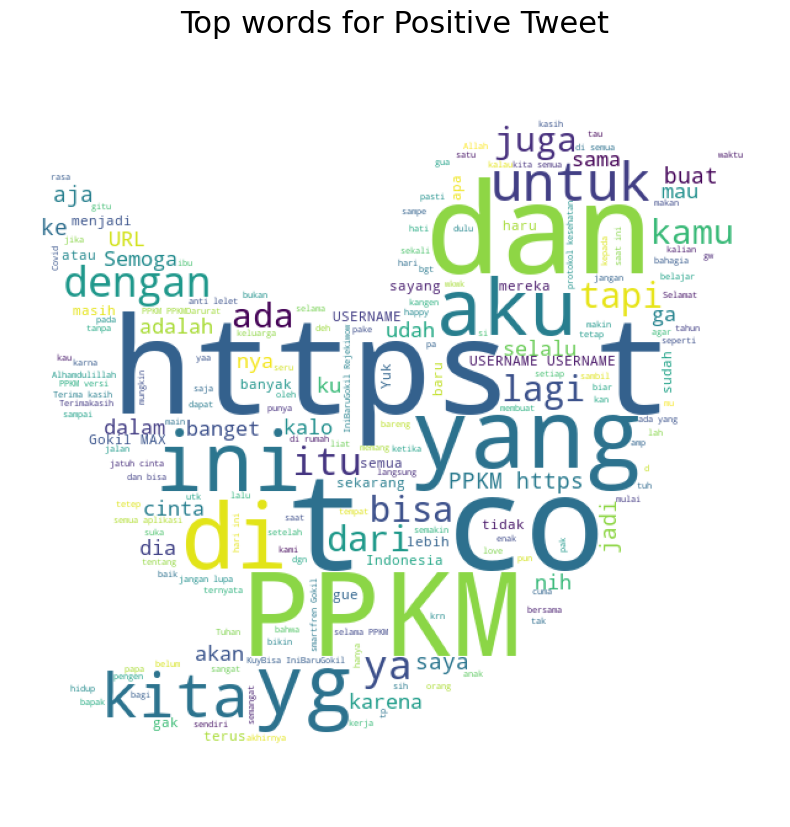

In [24]:
import requests
from PIL import Image
from io import BytesIO

url = "https://image.freepik.com/free-icon/twitter-logo_318-40459.jpg"  # replace with your image URL
response = requests.get(url)
twitter_mask = np.array(Image.open(BytesIO(response.content)))

wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 'positive', 'Tweet']))
plt.figure(figsize=(18,10))
plt.title('Top words for Positive Tweet',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

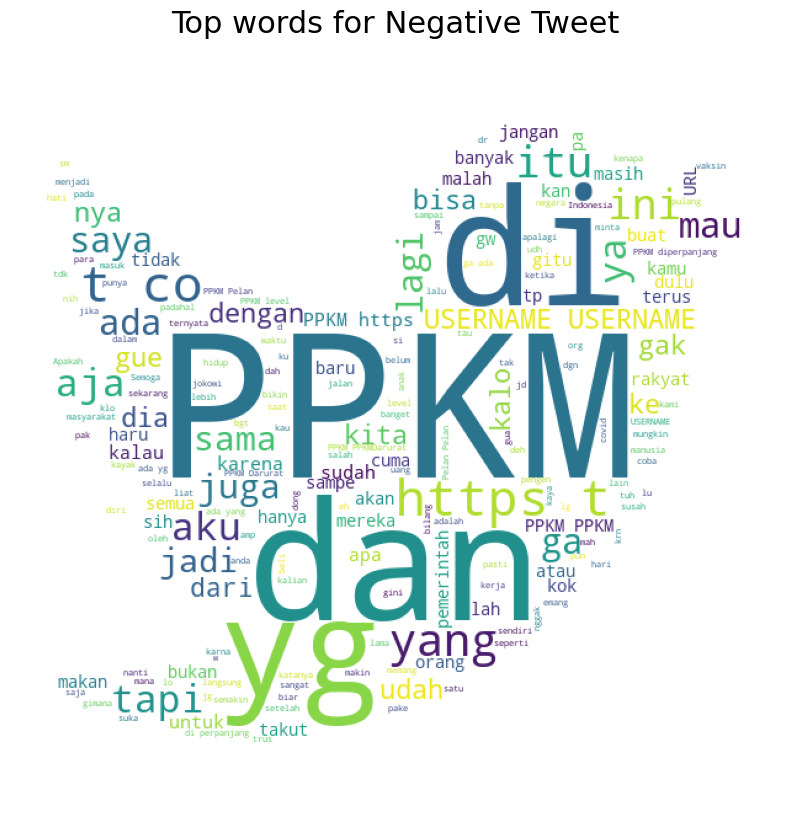

In [25]:
wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 'negative', 'Tweet']))
plt.figure(figsize=(18,10))
plt.title('Top words for Negative Tweet',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

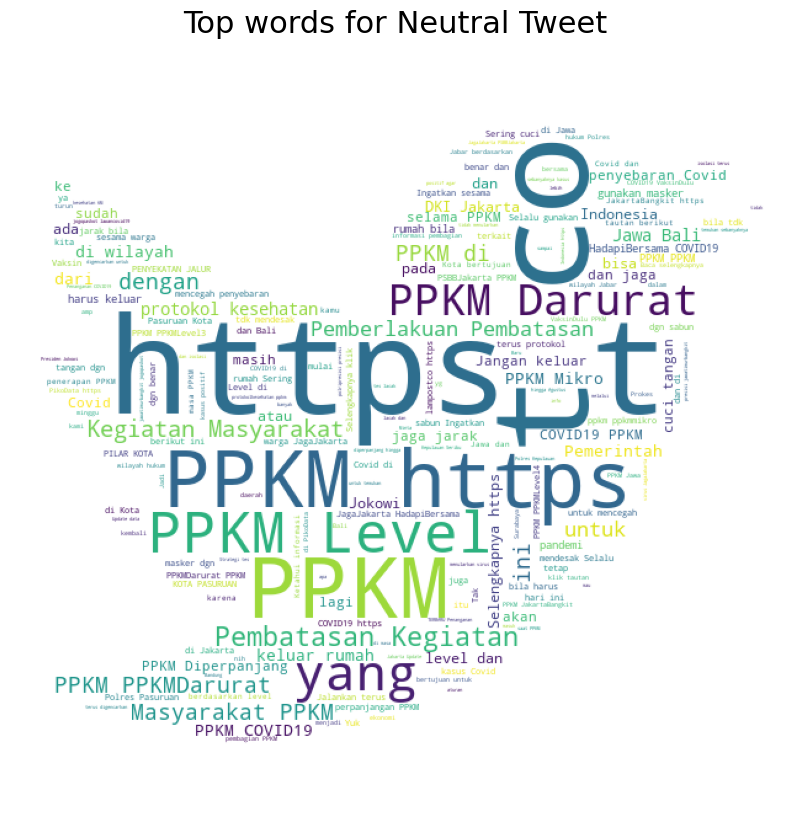

In [26]:
wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 'neutral', 'Tweet']))
plt.figure(figsize=(18,10))
plt.title('Top words for Neutral Tweet',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [27]:
x = df_train['Tweet']
y = df_train['label']

<a id='3'></a>
# <p style="background-color:#484949; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">[3. Data Preprocessing](#0)</p>

In [28]:
stopword_bahasa = pd.read_csv('https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/TextNormalization/stopwordbahasa.csv', encoding='latin-1')
stopword_bahasa = stopword_bahasa.rename(columns={0: 'stop'})
stopword_bahasa

,ada
0,adalah
1,adanya
2,adapun
3,agak
4,agaknya
...,...
752,wong
753,yaitu
754,yakin
755,yakni


In [29]:
kamus_alay = pd.read_csv('https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/TextNormalization/kamus_alay.csv', header=None, encoding='latin-1')
kamus_alay = kamus_alay.rename(columns={0: 'original',
                                     1: 'replacement'})
kamus_alay_map = dict(zip(kamus_alay['original'], kamus_alay['replacement']))
kamus_alay

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


In [30]:
kamus_singkatan = pd.read_csv('https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/TextNormalization/kamus_singkatan.csv', sep=';', encoding='latin-1')
kamus_singkatan.columns = ['Column1', 'Column2']
kamus_singkatan = kamus_singkatan.rename(columns={'Column1': 'original', 'Column2': 'replacement'})
kamus_singkatan_map = dict(zip(kamus_singkatan['original'], kamus_singkatan['replacement']))
kamus_singkatan

,original,replacement
0,adek,adik
1,adlh,adalah
2,aer,air
3,aiskrim,es krim
4,aj,saja
...,...,...
1300,yoi,iya
1301,yup,ya
1302,yups,ya
1303,yupz,ya


<a id='3.1'></a>
## <p style="background-color:#484949; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">[3.1 Cleaning](#0) </p>

In [31]:
# List of words to remove
remove_words = ['ppkm', 'covid']

def remove_unnecessary_char(text):
    text = text.lower()
    text = re.sub('\n', ' ', text) # Remove every newline character
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text) # Remove every username
    text = re.sub('user', ' ', text) # Remove every occurrence of the word 'user'
    text = re.sub('rt', ' ', text) # Remove every retweet symbol
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) # Remove every URL
    text = re.sub('https?://t\.me/[^\s]+', ' ', text) # Remove every Telegram link
    text = re.sub ('[^0-9a-zA-Z]+', ' ', text) # Remove every non-alphanumeric character
    text = re.sub('  +', ' ', text) # Remove extra spaces
    for word in remove_words:
        text = re.sub(word, '', text)  # remove word
    return text
x = x.apply(remove_unnecessary_char)
x.head()

3288     iya rebutan colokan pada penuh semua d dibis k...
11024    saya menjual anolyte baby sanitiz seharga rp22...
3482     shawn mendes kalo pas nyanyi tanpa kita liat o...
7753     idul adha di kota orang mbokne ancok tenan  id...
13616     kasus  meroket jokowi sebut 44 kabupaten dan ...
Name: Tweet, dtype: object

<a id='3.2'></a>
## <p style="background-color:#484949; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">[3.2 Normalization](#0)</p>

In [32]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Text preprocessing functions from previous script
def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def normalize_alay(text):
    return ' '.join([kamus_alay_map[word] if word in kamus_alay_map else word for word in text.split(' ')])

def normalize_singkatan(text):
    return ' '.join([kamus_singkatan_map[word] if word in kamus_singkatan_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join([ ' ' if word in stopword_bahasa.ada.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text_cleaning):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    do = []
    for w in text_cleaning:
        dt = stemmer.stem(w)
        do.append(dt)
    return ' '.join(do)

# Modified clean_text function that calls preprocessing functions from previous script
def preprocess(text):

    text = normalize_alay(text) # Normalize text using alay_dict_map
    text = normalize_singkatan(text) # Normalize text using alay_dict_map2
    text = remove_stopword(text) # Remove stopwords from text
    text = tokenizingText(text)
    text = stemming(text)
    return text
X_c = x.apply(preprocess)
X_c.head()

3288     iya rebut colok penuh bis karokean tuker2an ca...
11024    jual anolyte baby sanitiz harga rp225 000 dapa...
3482     shawn mendes pas nyanyi lihat orang bikin mese...
7753     idul adha kota orang mbokne jancuk benar iduladha
13616    roket jokowi 44 kabupaten 6 provinsi terap dar...
Name: Tweet, dtype: object

<a id='4'></a>
# <p style="background-color:#484949; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">[4. Tokenize & Padding](#0) 🪄</p>

In [33]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_c)

X = tokenizer.texts_to_sequences(X_c)
vocab_size = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(X_c[8]))
print("\nAfter tokenizing :\n{}".format(X[8]))

X = pad_sequences(X, padding='post')
print("\nAfter padding :\n{}".format(X[8]))

Vocabulary size: 25024

Example:

Sentence:
contoh gemar sudut teriak toleran gemar tuduh gemar men judge dasar versi

After tokenizing :
[10108, 10109, 61, 5274, 5275, 113, 10110]

After padding :
[10108 10109    61  5274  5275   113 10110     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]


In [34]:
sentiments = {'negative': 0,
            'neutral': 1,
            'positive':2,
           }
y = y.map(sentiments)
labels = ['negative', 'neutral', 'positive']

In [35]:
# List of words to remove
remove_words = ['ppkm', 'covid']
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def clean_char(text):
    text = text.lower()
    text = re.sub('\n', ' ', text) # Remove every newline character
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text) # Remove every username
    text = re.sub('user', ' ', text) # Remove every occurrence of the word 'user'
    text = re.sub('rt', ' ', text) # Remove every retweet symbol
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) # Remove every URL
    text = re.sub('https?://t\.me/[^\s]+', ' ', text) # Remove every Telegram link
    text = re.sub ('[^0-9a-zA-Z]+', ' ', text) # Remove every non-alphanumeric character
    text = re.sub('  +', ' ', text) # Remove extra spaces
    for word in remove_words:
        text = re.sub(word, '', text)  # remove word
    return text

# Text preprocessing functions from previous script
def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def normalize_alay(text):
    return ' '.join([kamus_alay_map[word] if word in kamus_alay_map else word for word in text.split(' ')])

def normalize_singkatan(text):
    return ' '.join([kamus_singkatan_map[word] if word in kamus_singkatan_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join([ ' ' if word in stopword_bahasa.ada.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text_cleaning):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    do = []
    for w in text_cleaning:
        dt = stemmer.stem(w)
        do.append(dt)
    return ' '.join(do)

# Modified clean_text function that calls preprocessing functions from previous script
def process(text):
    text = clean_char(text)
    text = normalize_alay(text) # Normalize text using alay_dict_map
    text = normalize_singkatan(text) # Normalize text using alay_dict_map2
    text = remove_stopword(text) # Remove stopwords from text
    text = tokenizingText(text)
    text = stemming(text)
    return text

In [36]:
X_test = df_test['Tweet'].copy()
y_test = df_test['label'].copy()

X_test = X_test.apply(process)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post', maxlen = X.shape[1])

y_test = y_test.map(sentiments)

<a id='5'></a>
# <p style="background-color:#484949; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">[5. Modelling](#0)</p>

<a id='5.1'></a>
## <p style="background-color:#484949; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">[5.1 Generic Model](#0)</p>

In [46]:
def generic_model(model_layer,units, epochs, bs):
    EPOCHS = epochs
    BATCH_SIZE = bs
    embedding_dim = 16

    model= tf.keras.Sequential([
        layer.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
        model_layer(units,return_sequences = True),
        layer.GlobalMaxPooling1D(),
        layer.Dense(3,activation = 'softmax')
    ])
    
    model.summary()
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

    model.compile(loss=SparseCategoricalCrossentropy(from_logits = False),
              optimizer='adam',metrics=['accuracy'])
            
    history = model.fit(X, y, epochs=EPOCHS, 
                        validation_split=0.15, batch_size=BATCH_SIZE,
                        callbacks = [callback])
    hist_model = pd.DataFrame(history.history)

    
    #Plot the loss and accuracy curves
    fig, ax = plt.subplots(2,1, figsize = (8,8))
    ax[0].plot(hist_model.loss, c = 'b')
    ax[0].plot(hist_model.val_loss, c = 'r')
    ax[0].set_title('Training and validation losses');
    ax[0].set_ylabel('Loss')
    ax[0].legend(['train', 'val'], loc='upper left')

    ax[1].plot(hist_model.accuracy, c = 'b')
    ax[1].plot(hist_model.val_accuracy, c = 'r')
    ax[1].set_title('Training and validation accuracies');
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    
    #Prediction
    pred = np.argmax(np.round(model.predict(X_test)),axis = 1)
    loss, acc = model.evaluate(X_test,y_test,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
    
     # Define the labels
    labels = ['Negative', 'Neutral', 'Positive']
    
    # Classification report
    print('Classification Report:')
    report = classification_report(y_test, pred, target_names=labels, output_dict=True)
    print(classification_report(y_test, pred, target_names=labels))    
    
    # Compute confusion matrix
    if len(y_test.shape) == 1:
        cm = confusion_matrix(y_test, pred)
    else:
        cm = confusion_matrix(np.argmax(y_test, axis=1), pred)

    # Define the labels
    labels = ['Negative', 'Neutral', 'Positive']

    # Create a ConfusionMatrixDisplay instance
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # Plot the confusion matrix using ConfusionMatrixDisplay
    plt.figure(figsize=(10, 10))
    disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()
                
    return model, hist_model, loss, acc, cm

## LSTM Model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 49, 16)            400384    
                                                                 
 lstm_4 (LSTM)               (None, 49, 15)            1920      
                                                                 
 global_max_pooling1d_4 (Glo  (None, 15)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 3)                 48        
                                                                 
Total params: 402,352
Trainable params: 402,352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
375/375 [==============================] - 9s 19ms/step - loss: 0.9067 - accuracy: 0.6050 - val_loss: 0.

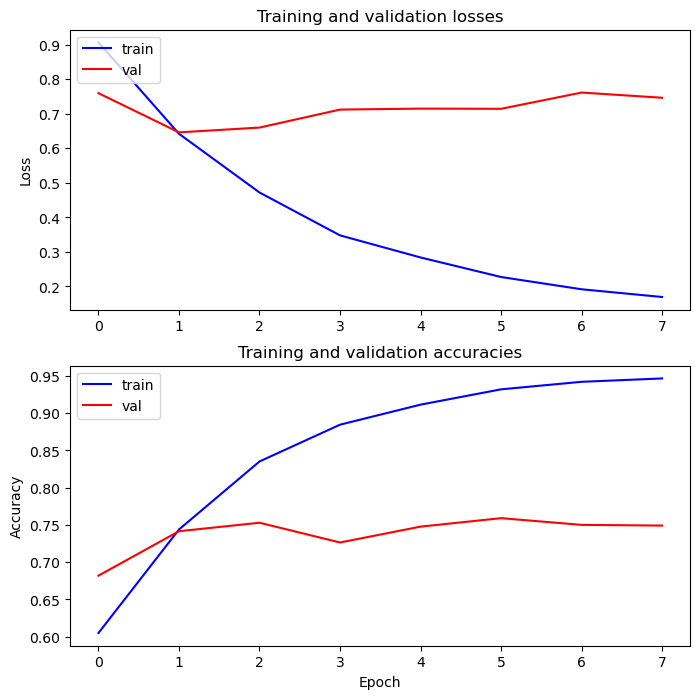

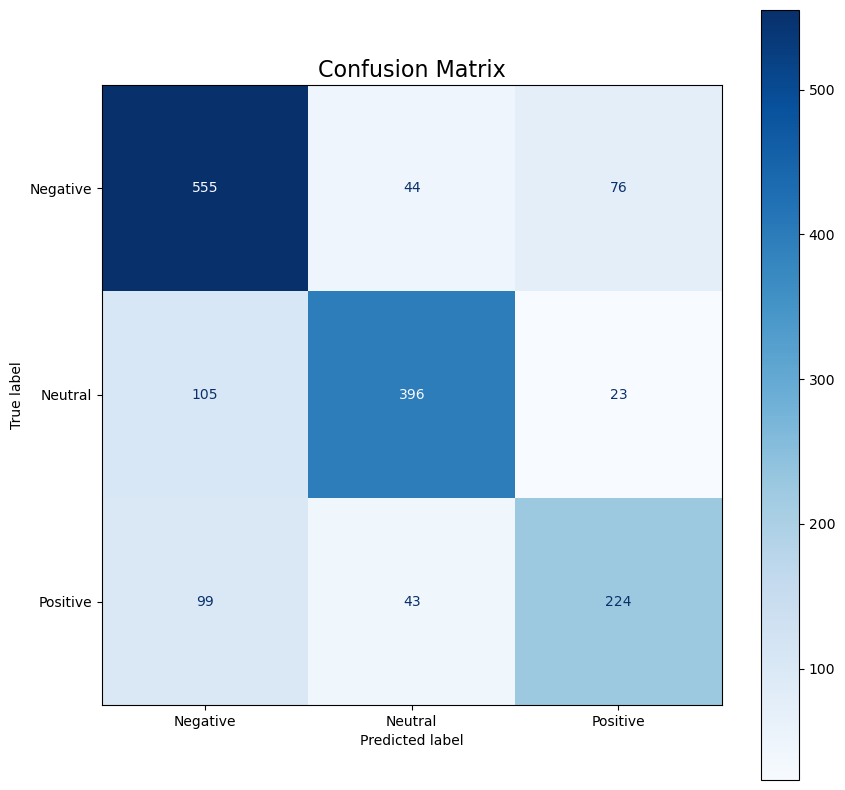

In [47]:
model_LSTM = generic_model(layer.LSTM,15, 8, 32)

## GRU Model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 49, 16)            400384    
                                                                 
 gru_1 (GRU)                 (None, 49, 15)            1485      
                                                                 
 global_max_pooling1d_4 (Glo  (None, 15)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 3)                 48        
                                                                 
Total params: 401,917
Trainable params: 401,917
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
375/375 [==============================] - 15s 31ms/step - loss: 0.8629 - accuracy: 0.6048 - val_loss: 0

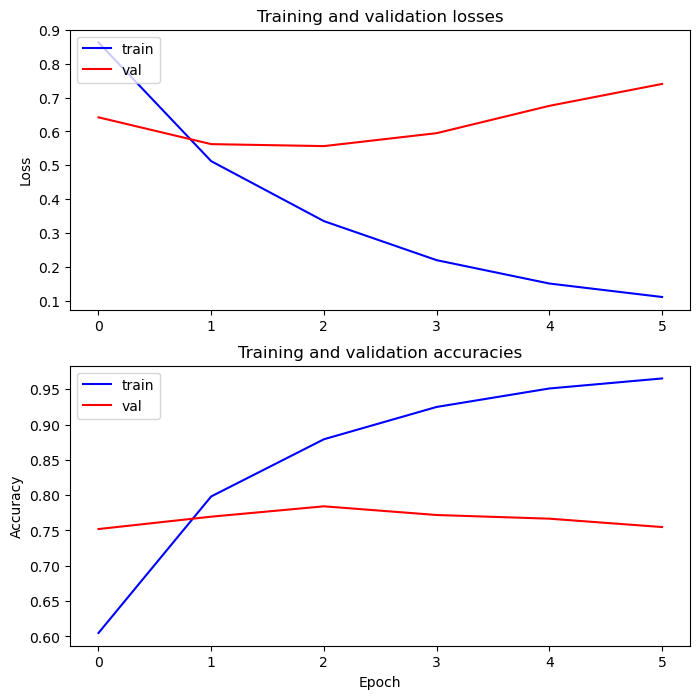

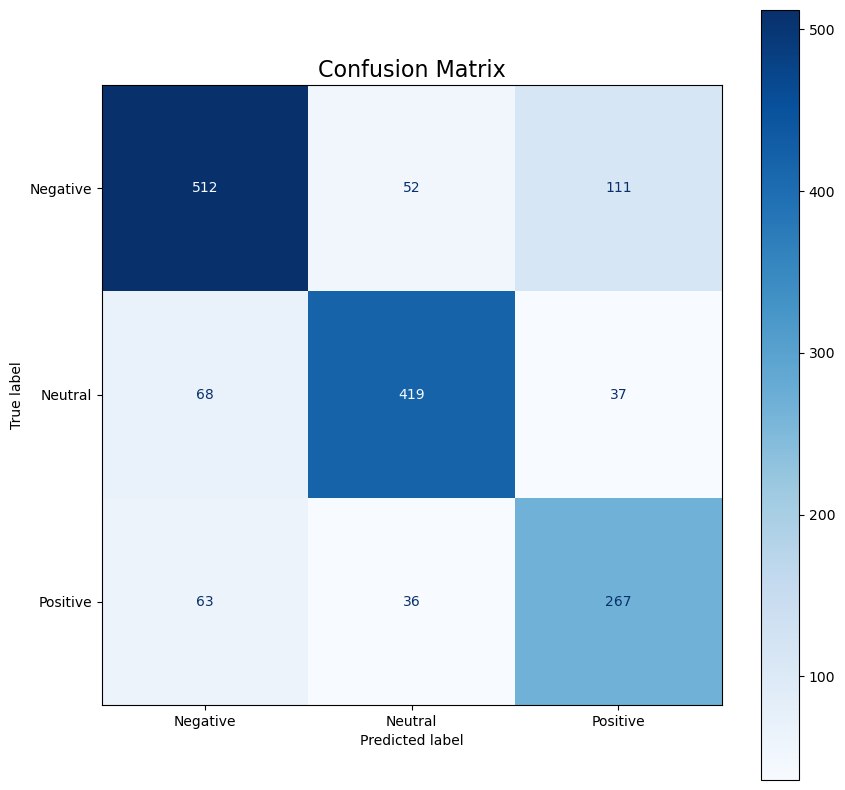

In [61]:
model_GRU = generic_model(layer.GRU,15, 6, 32)

<a id='5.2'></a>
## <p style="background-color:#484949; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">[5.2 Model with pretrained GloVe](#0)</p>

In [62]:
EMBEDDING_FILE = r"C:\Users\rizky\Downloads\glove twitter\glove.twitter.27B.200d.txt"

In [63]:
#EMBEDDING_DIM must equal the number ###d.txt
EMBEDDING_DIM = 200
MODEL_PATH = r'model.h5'

In [64]:
#Checking the number of word vectors
embeddings_index = {}

f = open(EMBEDDING_FILE)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 1193514 word vectors.


In [65]:
#Define the entries of the embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
embedding_matrix.shape

for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector

In [66]:
#Define the embedding layer for the neural network
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=X.shape[1],
                                          trainable=False)

In [69]:
def generic_model_pretrained_embedding(model_layer, units, epochs, bs, bidir=False):
#This function allows for a Bidirectional wrapper if the parameter bidir = True
    EPOCHS = epochs
    BATCH_SIZE = bs

    sequence_input = layer.Input(shape=(X.shape[1],),)
    embedding_sequences = embedding_layer(sequence_input)
    x = layer.SpatialDropout1D(0.2)(embedding_sequences)
    x = layer.Conv1D(32, 5, activation='relu')(x)
    if bidir:
        x = layer.Bidirectional(model_layer(units, return_sequences = True))(x)
    else:
        x = model_layer(units, return_sequences = True)(x)
    x = layer.GlobalMaxPooling1D()(x)
    outputs = layer.Dense(3, activation='softmax')(x)
    model = tf.keras.Model(sequence_input, outputs)
    model.summary()

    model.compile(loss=SparseCategoricalCrossentropy(from_logits = False),
              optimizer='adam',metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
    history = model.fit(X, y, epochs=EPOCHS,
                        validation_split=0.15, batch_size=BATCH_SIZE,
                       callbacks = [callback])
    hist_model = pd.DataFrame(history.history)


    #Plot the loss and accuracy curves
    fig, ax = plt.subplots(2,1, figsize = (8,8))
    ax[0].plot(hist_model.loss, c = 'b')
    ax[0].plot(hist_model.val_loss, c = 'r')
    ax[0].set_title('Training and validation loss');
    ax[0].set_ylabel('Loss')
    ax[0].legend(['train', 'val'], loc='upper left')

    ax[1].plot(hist_model.accuracy, c = 'b')
    ax[1].plot(hist_model.val_accuracy, c = 'r')
    ax[1].set_title('Training and validation accuracy');
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'val'], loc='upper left')

    #Prediction
    pred = np.argmax(np.round(model.predict(X_test)),axis = 1)
    loss, acc = model.evaluate(X_test,y_test,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))

    # Define the labels
    labels = ['Negative', 'Neutral', 'Positive']
    
    # Classification report
    print('Classification Report:')
    report = classification_report(y_test, pred, target_names=labels, output_dict=True)
    print(classification_report(y_test, pred, target_names=labels))    

    # Compute confusion matrix
    if len(y_test.shape) == 1:
        cm = confusion_matrix(y_test, pred)
    else:
        cm = confusion_matrix(np.argmax(y_test, axis=1), pred)

    # Define the labels
    labels = ['Negative', 'Neutral', 'Positive']

    # Create a ConfusionMatrixDisplay instance
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # Plot the confusion matrix using ConfusionMatrixDisplay
    plt.figure(figsize=(10, 10))
    disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

    return model, hist_model, loss, acc, cm

# LSTM Model with GloVe

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 49)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 49, 200)           5004800   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 49, 200)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_1 (Conv1D)           (None, 45, 32)            32032     
                                                                 
 lstm_4 (LSTM)               (None, 45, 15)            2880      
                                                                 
 global_max_pooling1d_6 (Glo  (None, 15)               0         
 balMaxPooling1D)                                          

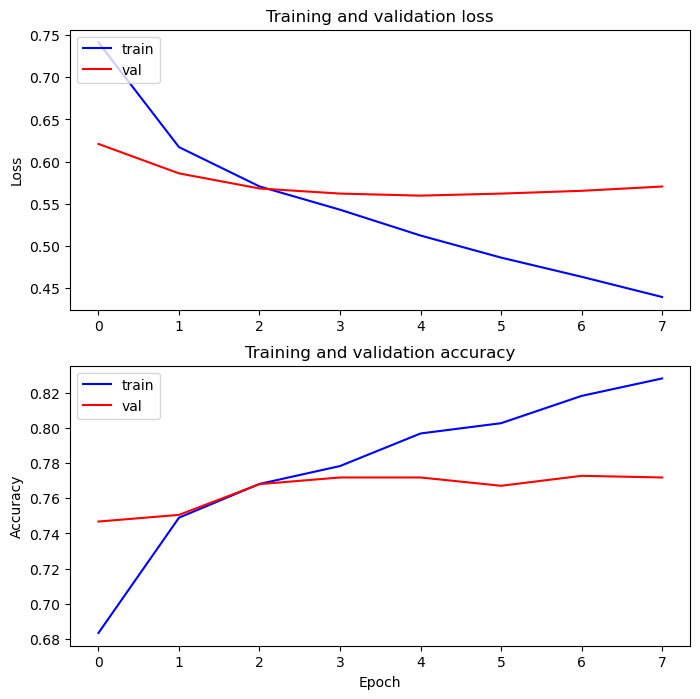

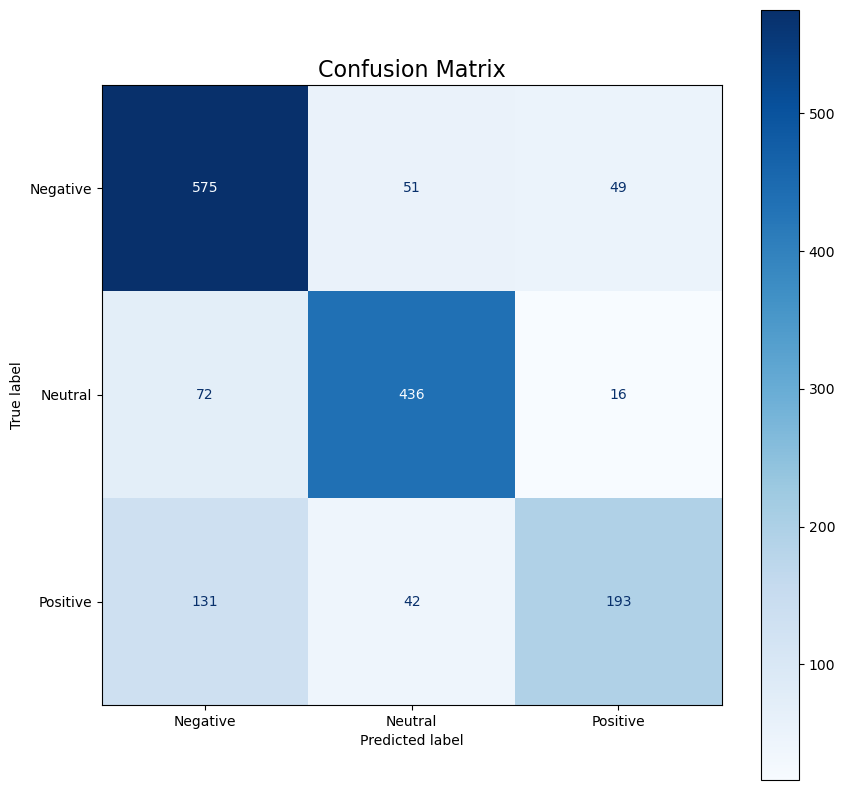

In [70]:
model_LSTM_G = generic_model_pretrained_embedding(layer.LSTM, 15, 8, 32)

# GRU Model with GloVe

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 49)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 49, 200)           5004800   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 49, 200)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 45, 32)            32032     
                                                                 
 gru_2 (GRU)                 (None, 45, 15)            2205      
                                                                 
 global_max_pooling1d_7 (Glo  (None, 15)               0         
 balMaxPooling1D)                                          

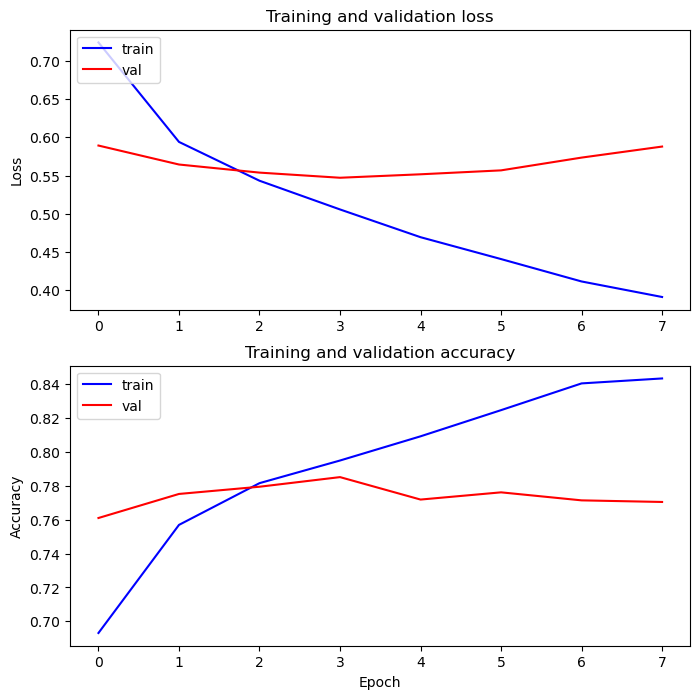

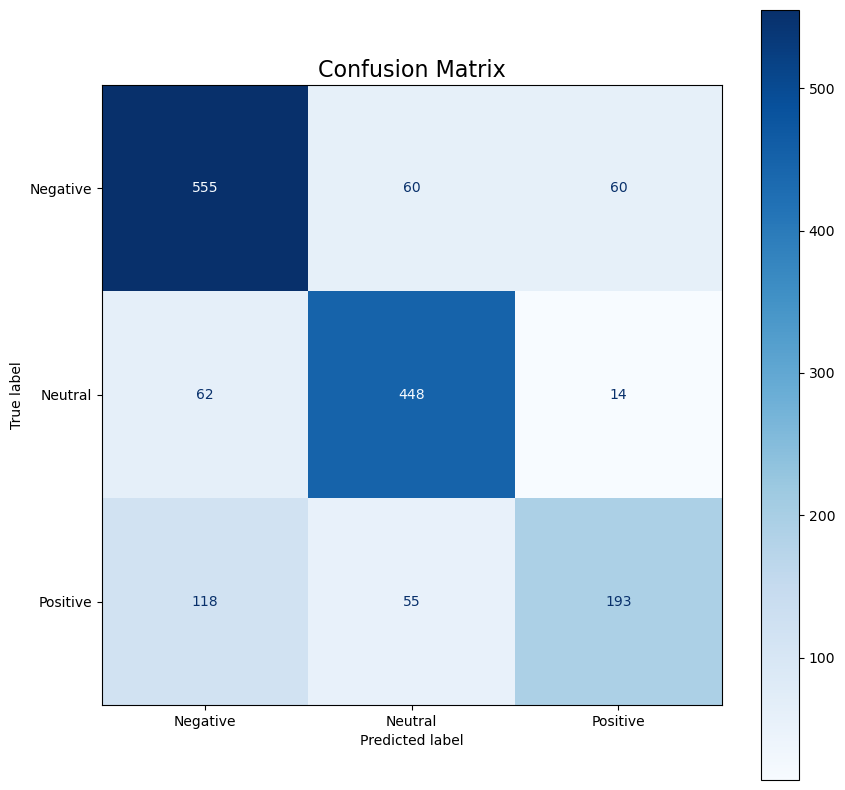

In [71]:
model_GRU_G = generic_model_pretrained_embedding(layer.GRU, 15, 8, 32)

# Bidirectional LSTM with GloVe

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 49)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 49, 200)           5004800   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 49, 200)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_3 (Conv1D)           (None, 45, 32)            32032     
                                                                 
 bidirectional (Bidirectiona  (None, 45, 30)           5760      
 l)                                                              
                                                                 
 global_max_pooling1d_8 (Glo  (None, 30)               0   

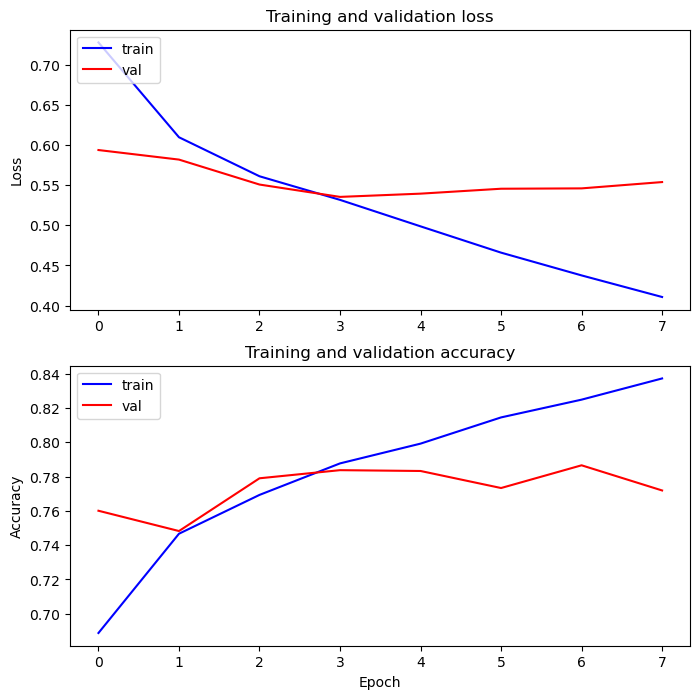

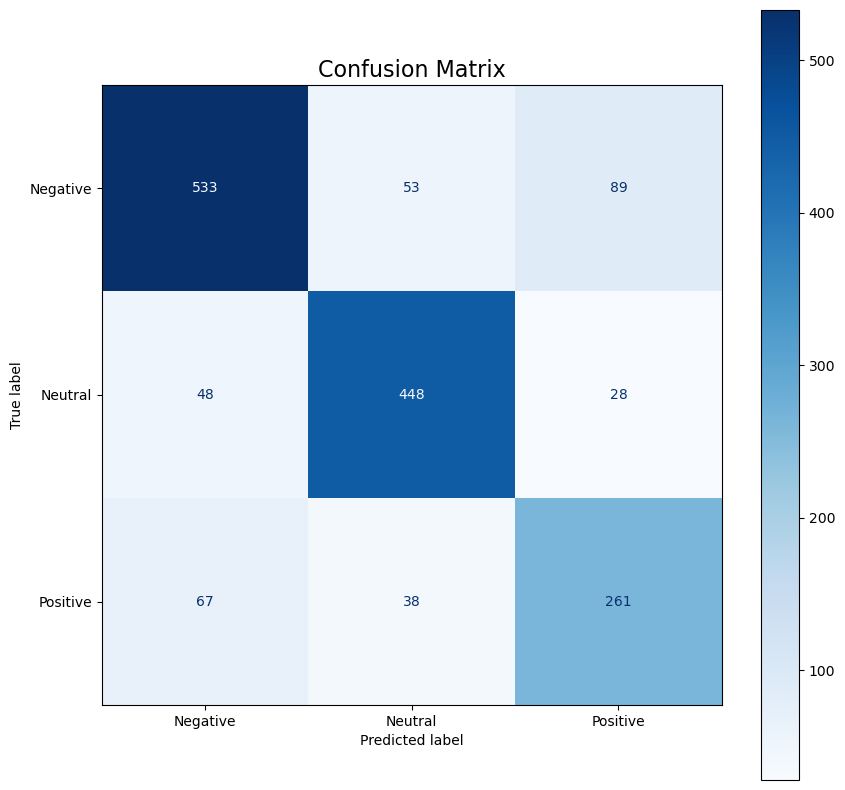

In [72]:
model_bLSTM_G = generic_model_pretrained_embedding(layer.LSTM, 15, 8, 32,bidir = True)

<a id='5.3'></a>
## <p style="background-color:#484949; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">[5.3 Model with Pretrained FastText](#0)</p>

In [80]:
# Load FastText model using Gensim
EMBEDDING_FILE = r"C:\Users\rizky\OneDrive\Dokumen\Pre Trained Word Embedding\Fastext_model_tweet.bin"
EMBEDDING_DIM = 100
fasttext_model = load_facebook_model(EMBEDDING_FILE)
print("Ada %s vektor kata yang ditemukan dalam model FastText" % len(fasttext_model.wv))

Ada 69465 vektor kata yang ditemukan dalam model FastText


In [82]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    try:
        embedding_vector = fasttext_model.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [83]:
# Define the embedding layer for the neural network
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],
                                            input_length=X.shape[1],
                                            trainable=False)

In [85]:
def generic_model_pretrained_embedding_fasttext(model_layer, units, epochs, bs, bidir=False):
    EPOCHS = epochs
    BATCH_SIZE = bs

    sequence_input = Input(shape=(X.shape[1],))
    embedding_sequences = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Conv1D(32, 5, activation='relu')(x)
    if bidir:
        x = tf.keras.layers.Bidirectional(model_layer(units, return_sequences=True))(x)
    else:
        x = model_layer(units, return_sequences=True)(x)
    x = GlobalMaxPooling1D()(x)
    outputs = Dense(3, activation='softmax')(x)
    model = tf.keras.Model(sequence_input, outputs)
    model.summary()

    model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),
                  optimizer='adam', metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
    history = model.fit(X, y, epochs=EPOCHS,
                        validation_split=0.15, batch_size=BATCH_SIZE,
                        callbacks=[callback])
    hist_model = pd.DataFrame(history.history)

    # Plot the loss and accuracy curves
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    ax[0].plot(hist_model.loss, c='b')
    ax[0].plot(hist_model.val_loss, c='r')
    ax[0].set_title('Training and validation losses')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['train', 'val'], loc='upper left')

    ax[1].plot(hist_model.accuracy, c='b')
    ax[1].plot(hist_model.val_accuracy, c='r')
    ax[1].set_title('Training and validation accuracies')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'val'], loc='upper left')

    # Prediction
    pred = np.argmax(np.round(model.predict(X_test)), axis=1)
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))

     # Define the labels
    labels = ['Negative', 'Neutral', 'Positive']
    
    # Classification report
    print('Classification Report:')
    report = classification_report(y_test, pred, target_names=labels, output_dict=True)
    print(classification_report(y_test, pred, target_names=labels))    

    # Compute confusion matrix
    if len(y_test.shape) == 1:
        cm = confusion_matrix(y_test, pred)
    else:
        cm = confusion_matrix(np.argmax(y_test, axis=1), pred)

    # Define the labels
    labels = ['Negative', 'Neutral', 'Positive']

    # Create a ConfusionMatrixDisplay instance
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # Plot the confusion matrix using ConfusionMatrixDisplay
    plt.figure(figsize=(10, 10))
    disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

    return model, hist_model, loss, acc, cm

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 49)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 49, 100)           2502400   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 49, 100)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_4 (Conv1D)           (None, 45, 32)            16032     
                                                                 
 lstm_6 (LSTM)               (None, 45, 15)            2880      
                                                                 
 global_max_pooling1d_9 (Glo  (None, 15)               0         
 balMaxPooling1D)                                          

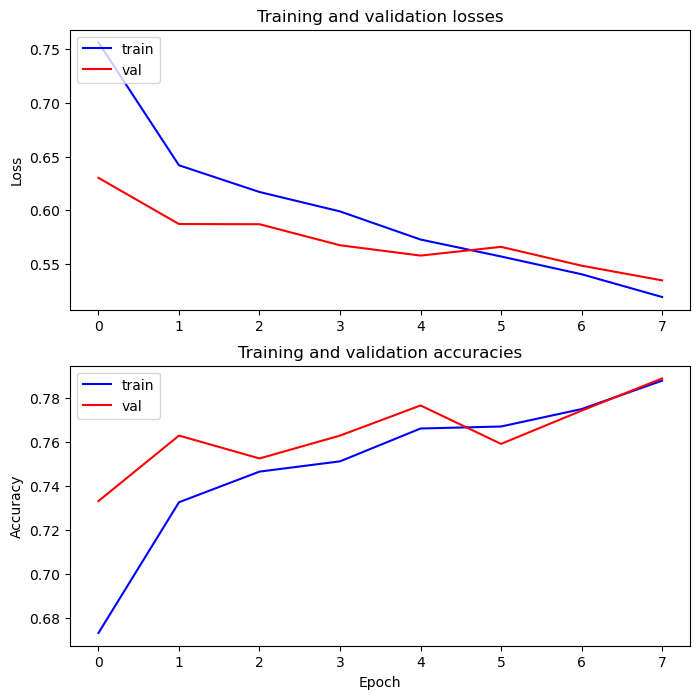

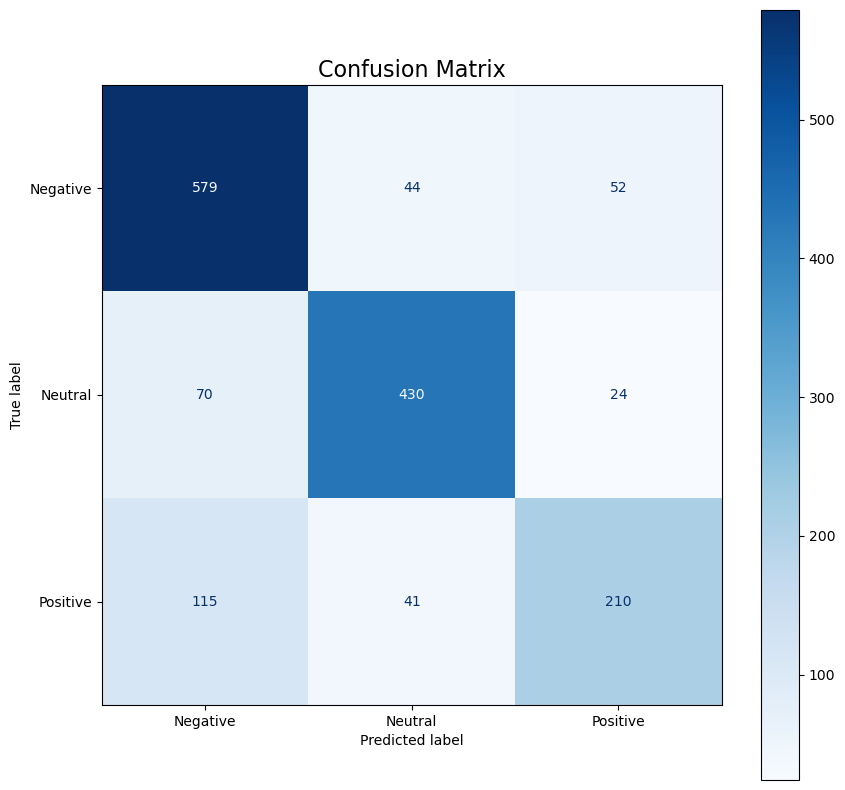

In [86]:
model_LSTM_FASTTEXT = generic_model_pretrained_embedding_fasttext(tf.keras.layers.LSTM, 15, 8, 32)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 49)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 49, 100)           2502400   
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 49, 100)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_5 (Conv1D)           (None, 45, 32)            16032     
                                                                 
 bidirectional_1 (Bidirectio  (None, 45, 30)           5760      
 nal)                                                            
                                                                 
 global_max_pooling1d_10 (Gl  (None, 30)               0   

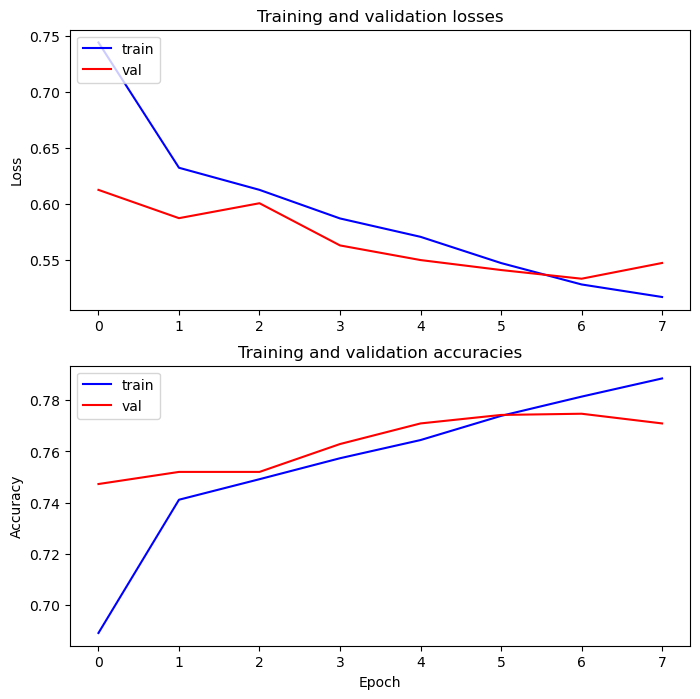

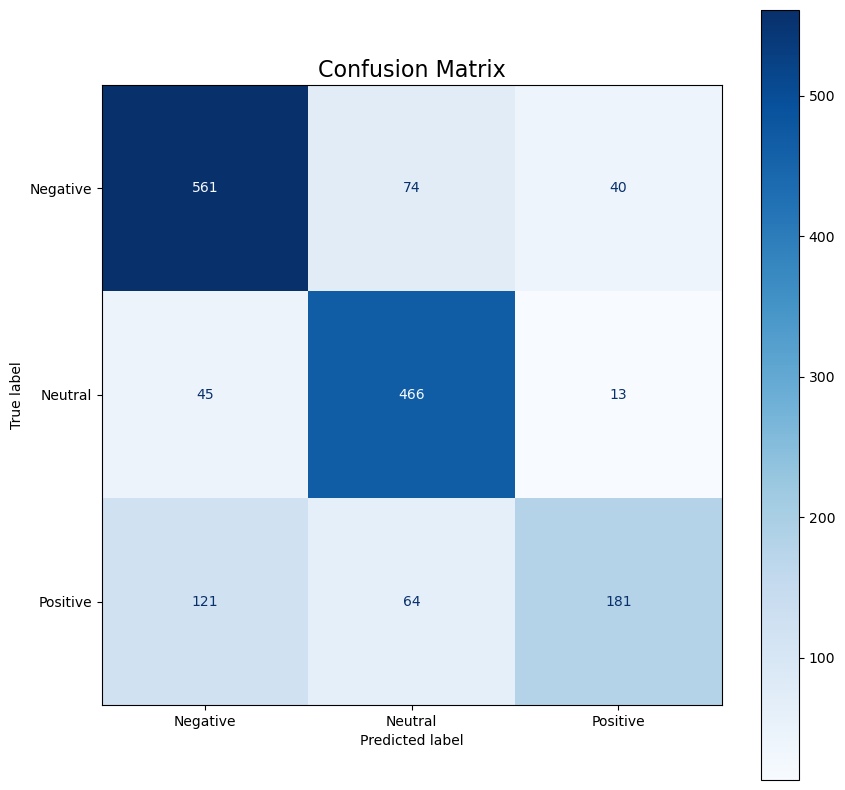

In [87]:
model_biLSTM_FASTTEXT = generic_model_pretrained_embedding_fasttext(tf.keras.layers.LSTM, 15, 8, 32, bidir=True)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 49)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 49, 100)           2502400   
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 49, 100)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_6 (Conv1D)           (None, 45, 32)            16032     
                                                                 
 bidirectional_2 (Bidirectio  (None, 45, 30)           4410      
 nal)                                                            
                                                                 
 global_max_pooling1d_11 (Gl  (None, 30)               0   

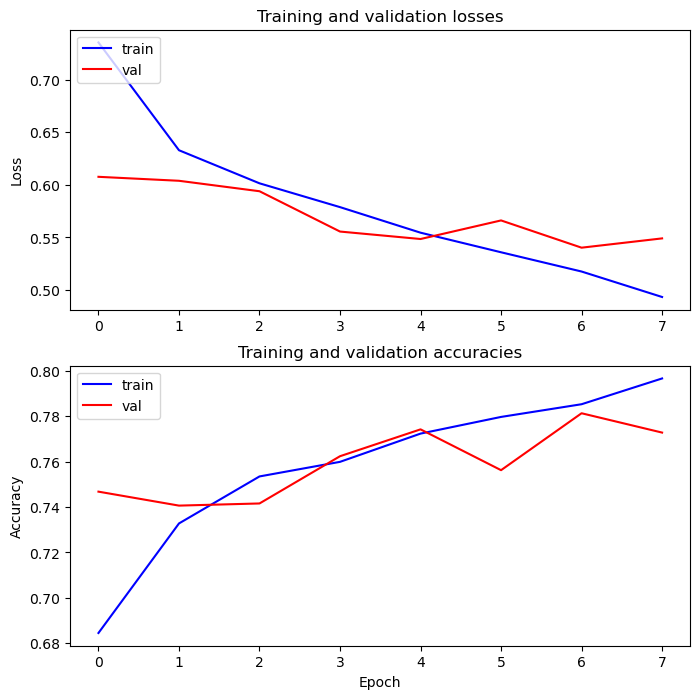

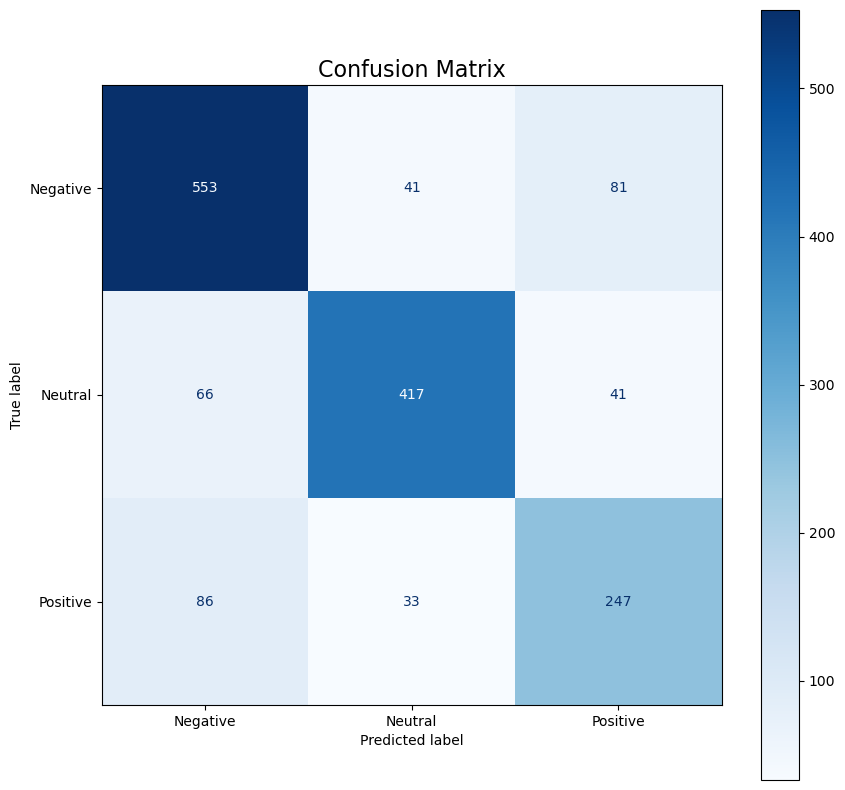

In [88]:
model_GRU_FASTTEXT = generic_model_pretrained_embedding_fasttext(tf.keras.layers.GRU, 15, 8, 32, bidir=True)

<a id='6'></a>
# <p style="background-color:#484949; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">[6. Comparison of accuracy between each model](#0)</p>

In [94]:
# Extract the accuracy values correctly as floats
model_LSTM_accuracy = model_LSTM[3] if isinstance(model_LSTM[3], float) else model_LSTM[3][1]
model_GRU_accuracy = model_GRU[3] if isinstance(model_GRU[3], float) else model_GRU[3][1]
model_LSTM_G_accuracy = model_LSTM_G[3] if isinstance(model_LSTM_G[3], float) else model_LSTM_G[3][1]
model_bLSTM_G_accuracy = model_bLSTM_G[3] if isinstance(model_bLSTM_G[3], float) else model_bLSTM_G[3][1]
model_GRU_G_accuracy = model_GRU_G[3] if isinstance(model_GRU_G[3], float) else model_GRU_G[3][1]
model_LSTM_FASTTEXT_accuracy = model_LSTM_FASTTEXT[3] if isinstance(model_LSTM_FASTTEXT[3], float) else model_LSTM_FASTTEXT[3][1]
model_biLSTM_FASTTEXT_accuracy = model_biLSTM_FASTTEXT[3] if isinstance(model_biLSTM_FASTTEXT[3], float) else model_biLSTM_FASTTEXT[3][1]
model_GRU_FASTTEXT_accuracy = model_GRU_FASTTEXT[3] if isinstance(model_GRU_FASTTEXT[3], float) else model_GRU_FASTTEXT[3][1]

In [97]:
# Assuming you have the models trained and stored in variables like model_LSTM_FASTTEXT, model_GRU_FASTTEXT, etc.
dc = {
    'Networks': ['LSTM', 'GRU', 'LSTM_G', 'biLSTM_G', 'GRU_G', 'LSTM_FASTTEXT', 'biLSTM_FASTTEXT', 'GRU_FASTTEXT'],
    'Accuracy': [
        model_LSTM_accuracy, model_GRU_accuracy, model_LSTM_G_accuracy, model_bLSTM_G_accuracy, model_GRU_G_accuracy,
        model_LSTM_FASTTEXT_accuracy, model_biLSTM_FASTTEXT_accuracy, model_GRU_FASTTEXT_accuracy
    ]
}
dfc = pd.DataFrame(dc)
dfc = dfc.set_index('Networks')

In [98]:
# Function to apply styling
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

# Apply styling to DataFrame
styled_dfc = dfc.style.apply(highlight_max, subset=['Accuracy'])
styled_dfc

,Accuracy
Networks,
LSTM,0.768051
GRU,0.761022
LSTM_G,0.777636
biLSTM_G,0.794249
GRU_G,0.766773
LSTM_FASTTEXT,0.782748
biLSTM_FASTTEXT,0.780192
GRU_FASTTEXT,0.778914


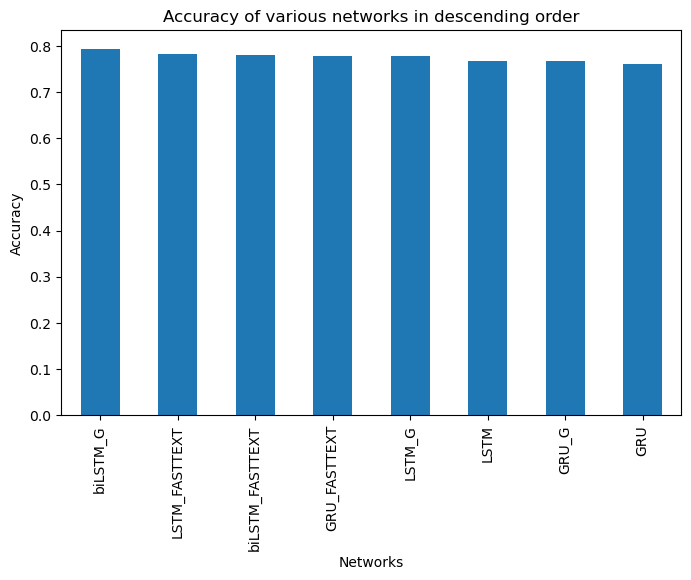

In [99]:
plt.figure(figsize =(8,5))
dfc['Accuracy'].sort_values(ascending = False).plot(kind = 'bar')
plt.ylabel('Accuracy')
plt.title('Accuracy of various networks in descending order');

In [100]:
# Create a dictionary to map network names to model objects
models = {
    'LSTM': model_LSTM,
    'GRU': model_GRU,
    'LSTM_G': model_LSTM_G,
    'biLSTM_G': model_bLSTM_G,
    'GRU_G': model_GRU_G,
    'LSTM_FASTTEXT': model_LSTM_FASTTEXT,
    'biLSTM_FASTTEXT': model_biLSTM_FASTTEXT,
    'GRU_FASTTEXT': model_GRU_FASTTEXT
}

# Identify the model with the highest accuracy
max_accuracy_network = dfc['Accuracy'].idxmax()
max_accuracy_model = models[max_accuracy_network]

# Save the model with the highest accuracy
max_accuracy_model[0].save('best_model.h5')

print(f"The model with the highest accuracy is {max_accuracy_network} with an accuracy of {dfc['Accuracy'].max()}")

The model with the highest accuracy is biLSTM_G with an accuracy of 0.7942491769790649
